In [362]:
import numpy as np
import pandas as pd
import re
import pickle
import itertools
from __future__ import print_function
from __future__ import division
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt
import csv
from datetime import datetime


# SK-learn libraries for learning.
#from sklearn.pipeline import Pipeline
#from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDClassifier

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# NLTK libs
from nltk.tokenize import TweetTokenizer

# Load Data

In [363]:
## Load combined comments
data_path = "/Users/kwheatley/Desktop/w266_nfl/"
combined_comments = 'Combined_Comments.csv'

df = pd.read_csv(data_path+combined_comments)
df.head(2)

,comment_id,author,author_flair,score,comment_name,comment_fullname,comment_is_root,comment_parent,comment_created,comment_created_utc,comment_created_utc_datetime,comment_created_utc_date,comment_created_utc_time,comment_depth,comment_body,submission_id,submission_title,submission_created_utc
0,drpk9pw,Corrupt-Spartan,Bengals,35,t1_drpk9pw,t1_drpk9pw,True,7lwbh9,1.514171e+09,1.514142e+09,2017-12-24 14:06:08,24-12-17,14:06:08,0,I love Lions fans cause we can drink bleach together this christmas eve,7lwbh9,Game Thread: Detroit Lions (8-6) at Cincinnati Bengals (5-9),1.514137e+09
1,drpqgru,byniri_returns,Lions,27,t1_drpqgru,t1_drpqgru,True,7lwbh9,1.514178e+09,1.514149e+09,2017-12-24 16:01:57,24-12-17,16:01:57,0,"I was back and forth with this, but I'm on the Fire Caldwell train now. This is embarrassing.",7lwbh9,Game Thread: Detroit Lions (8-6) at Cincinnati Bengals (5-9),1.514137e+09


In [378]:
# Reformat time variable
data.comment_created_utc_date = \
    data.comment_created_utc_date.map(lambda x: datetime.strptime(x,'%d-%m-%y'))

# Create Target Variable

In [367]:
df = df.fillna("no value")
df['bandwagon'] = df.author_flair.str.contains("Bandwagon").astype(int)
df['author_flair_nobandwagon'] = df['author_flair'].apply(lambda x: str(x).replace(' - Bandwagon',''))
df['fan_of_team_playing'] = df.apply(lambda x: x['author_flair_nobandwagon'] in x['submission_title'], axis=1)
df['fan_of_team_playing'] = df['fan_of_team_playing'].astype(int)
df['fan_of_team_playing_w_bandwagon'] = \
    np.where((df.fan_of_team_playing==1) & (df.bandwagon==1),2,
             np.where((df.fan_of_team_playing==1) & (df.bandwagon==0),1,0))
data = df

In [368]:
data.head(2)

,comment_id,author,author_flair,score,comment_name,comment_fullname,comment_is_root,comment_parent,comment_created,comment_created_utc,...,comment_created_utc_time,comment_depth,comment_body,submission_id,submission_title,submission_created_utc,bandwagon,author_flair_nobandwagon,fan_of_team_playing,fan_of_team_playing_w_bandwagon
0,drpk9pw,Corrupt-Spartan,Bengals,35,t1_drpk9pw,t1_drpk9pw,True,7lwbh9,1.514171e+09,1.514142e+09,...,14:06:08,0,I love Lions fans cause we can drink bleach together this christmas eve,7lwbh9,Game Thread: Detroit Lions (8-6) at Cincinnati Bengals (5-9),1.514137e+09,0,Bengals,1,1
1,drpqgru,byniri_returns,Lions,27,t1_drpqgru,t1_drpqgru,True,7lwbh9,1.514178e+09,1.514149e+09,...,16:01:57,0,"I was back and forth with this, but I'm on the Fire Caldwell train now. This is embarrassing.",7lwbh9,Game Thread: Detroit Lions (8-6) at Cincinnati Bengals (5-9),1.514137e+09,0,Lions,1,1


In [369]:
# Comment count
data['comment_body'].count()

2018028

# Remove Problematic Comments

In [370]:
# Remove empty comments
data = data[data.comment_body != "no value"]

In [371]:
# Remove Superbowl, Wildcard threads
data = data[
(data.submission_title!='Super Bowl LII Game Thread: Philadelphia Eagles (15-3) at New England Patriots (15-3)') &
(data.submission_title!='Super Bowl LII Game Thread: Philadelphia Eagles (15-3) at New England Patriots (15-3) (Second Half)') &
(data.submission_title!='Super Bowl 51 Pre Game Thread: New England Patriots (14-2) at Atlanta Falcons (11-5)') &
(data.submission_title!='Super Bowl 51 Post Game Thread: New England Patriots (14-2) at Atlanta Falcons (11-5)') &
(data.submission_title!='Game Thread: Atlanta Falcons (10-6) at Los Angeles Rams (11-5)') &
(data.submission_title!='Game Thread: Tennessee Titans (9-7) at Kansas City Chiefs (10-6)') &
(data.submission_title!='Game Thread: Buffalo Bills (9-7) at Jacksonville Jaguars (10-6)') &
(data.submission_title!='Game Thread: Carolina Panthers (11-5) at New Orleans Saints (11-5)') &
(data.submission_title!='Game Thread: Atlanta Falcons (11-6) at Philadelphia Eagles (13-3)') &
(data.submission_title!='Game Thread: Tennessee Titans (10-7) at New England Patriots (13-3)') &
(data.submission_title!='Game Thread: Jacksonville Jaguars (11-6) at Pittsburgh Steelers (13-3)') &
(data.submission_title!='Game Thread: Jacksonville Jaguars (12-6) at New England Patriots (14-3)') &
(data.submission_title!='Game Thread: Minnesota Vikings (14-3) at Philadelphia Eagles (14-3)') 
]

In [372]:
# New comment count
data['comment_body'].count()

1563467

# Create graphs

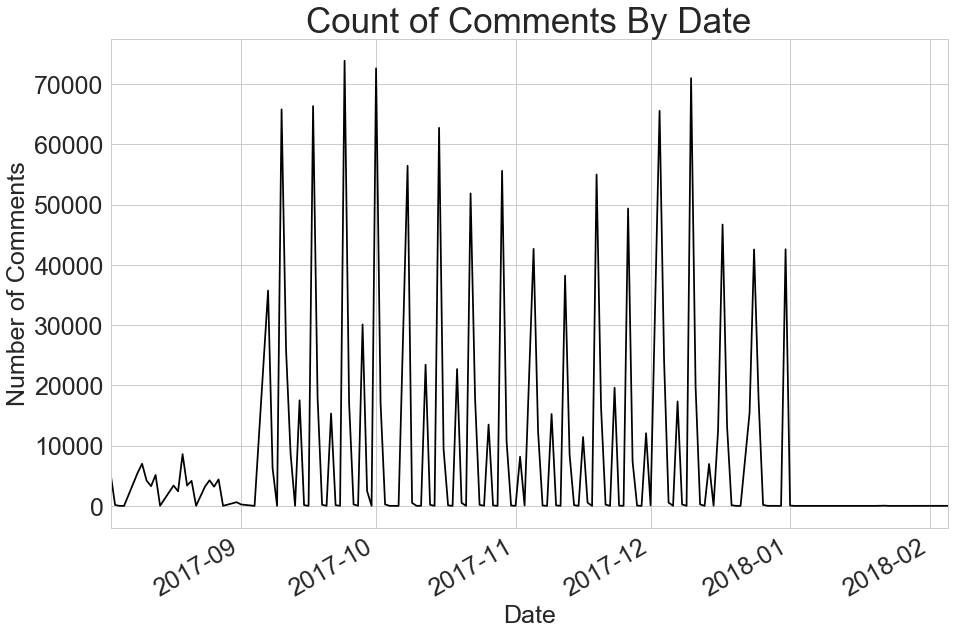

In [379]:
# This histogram is used for count of comments over time
plt.figure(figsize=(15,10))

ts = data.groupby('comment_created_utc_date')['comment_body'].count()
ax = ts.plot(cmap="gray")
plt.title('Count of Comments By Date',fontsize=35)
ax.set_ylabel('Number of Comments',fontsize=25)
ax.set_xlabel('Date',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.show()

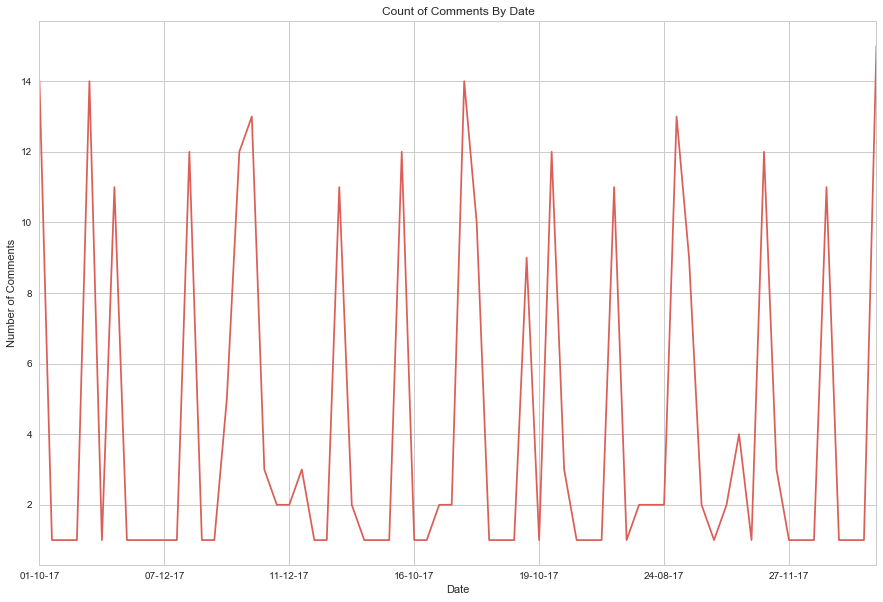

In [374]:
# This histogram gives the number of games over time
plt.figure(figsize=(15,10))

temp_data = pd.DataFrame(data.groupby(['comment_created_utc_date','submission_title'])['comment_body'].count().reset_index())

temp_data = temp_data[temp_data.comment_body>500]\
    .groupby('comment_created_utc_date')['submission_title'].nunique()

# temp_data
# temp_data[temp_data.comment_body>500].sort_values("comment_body").to_csv("temp.csv")
ax = temp_data.plot()
plt.title('Count of Comments By Date')
ax.set_ylabel('Number of Comments')
ax.set_xlabel('Date')
ax.set_xlabel('Date')
plt.show()


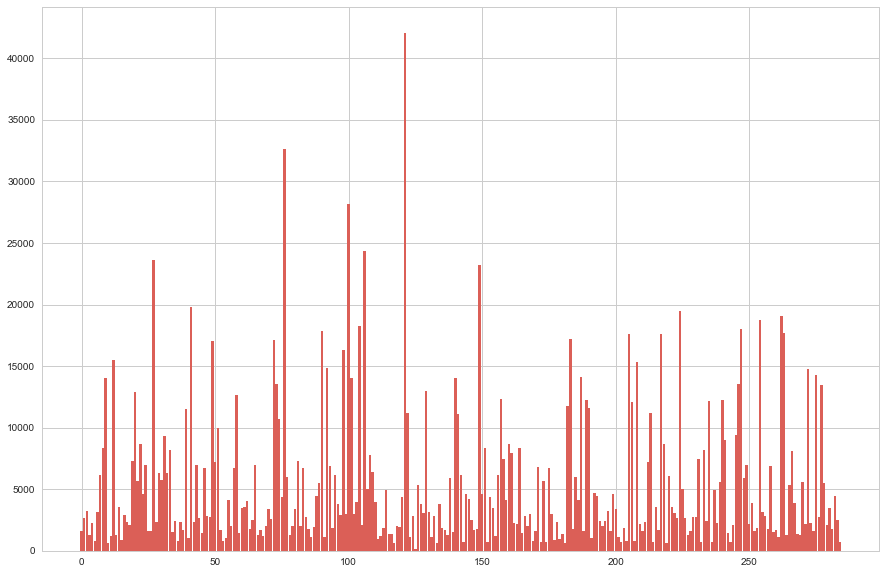

In [375]:
# This gives you the comment counts per game
plt.figure(figsize=(15,10))
labels, values = zip(*Counter(data.submission_title).items())

indexes = np.arange(len(labels))
width = .9

plt.bar(indexes, values, width)
# plt.xticks(indexes, labels,rotation='vertical')
plt.show()

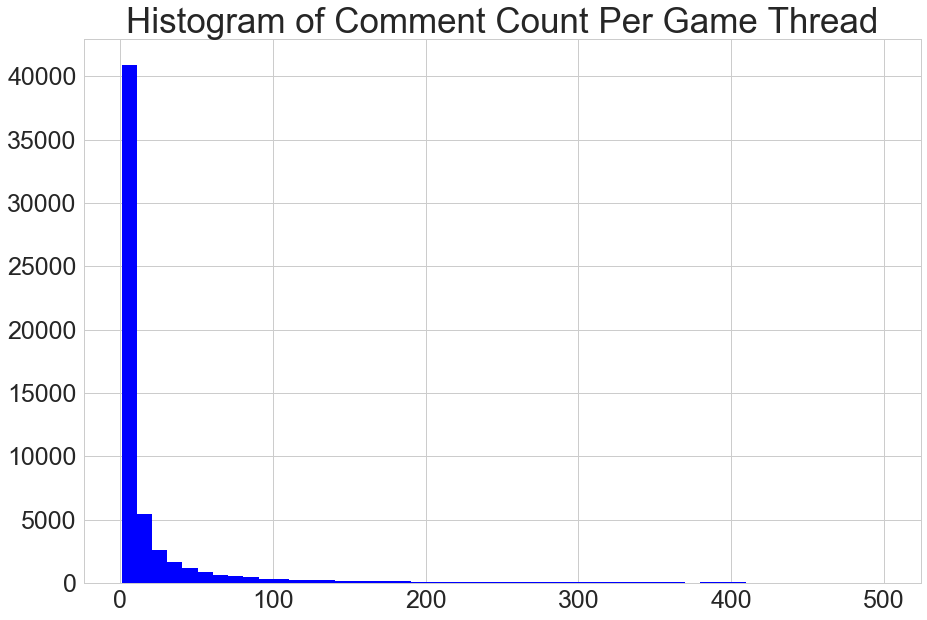

In [376]:
# This gives you the histogram of comment size per game
hist_data = pd.DataFrame(data.groupby("author")['comment_body'].count().reset_index())

plt.figure(figsize=(15,10))
ax = pd.DataFrame.hist(hist_data[hist_data.comment_body<500],
                 column='comment_body',bins=50,figsize=(15,10), ylabelsize=25, xlabelsize=25, color='blue')
plt.title('Histogram of Comment Count Per Game Thread',fontsize=35)
plt.show()

plt.figure(figsize=(15,10))
# hist_data = pd.DataFrame(data.groupby("submission_title")['comment_body'].count().reset_index())['comment_body']
# ax = plt.hist(hist_data, bins=50,facecolor='gray')  
# plt.title('Histogram of Comment Count Per Game Thread')
# # plt.xlabel('Number of Comments')
# # ax.set_xticks('Date')
# # ax.tick_params(axis='both', which='major', labelsize=18)
# plt.show()


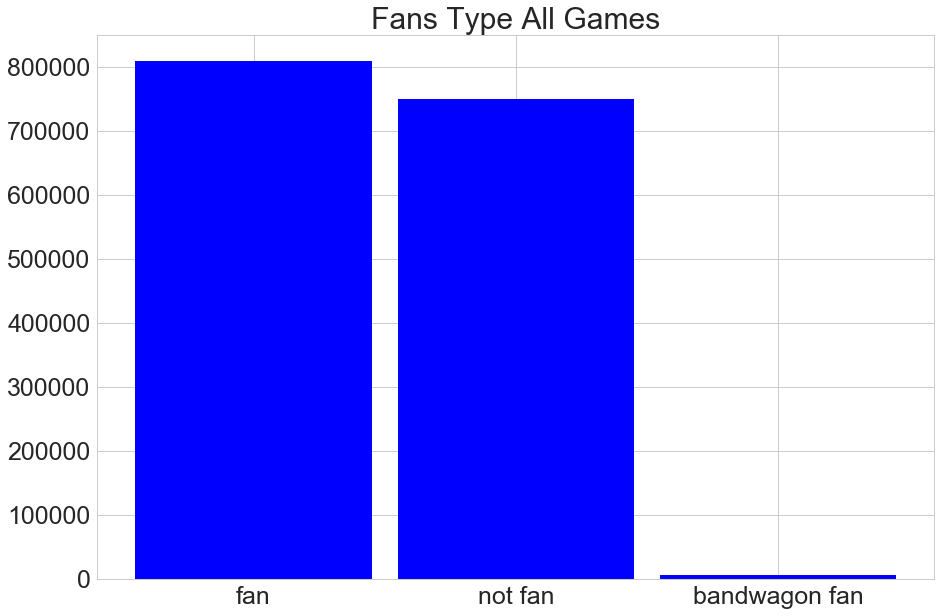

In [377]:
# Show the number of bandwagon fans. Since it is such a small percentage, 
# it's not important to look into.
labels, values = zip(*Counter(data.fan_of_team_playing_w_bandwagon).items())

indexes = np.arange(len(labels))
width = .9

labels = ["fan","not fan","bandwagon fan"]
plt.bar(indexes, values, width,color='blue')
plt.tick_params(axis='both', which='major', labelsize=25)
plt.title('Fans Type All Games',fontsize=30)
plt.xticks(indexes, labels,fontsize=25)
plt.show()

# Data Preprocessing

In [380]:
# Borrowed some functions from the w266 utils.py file
# Miscellaneous helpers
def flatten(list_of_lists):
    """Flatten a list-of-lists into a single list."""
    return list(itertools.chain.from_iterable(list_of_lists))


# Word processing functions
def canonicalize_digits(word):
    if any([c.isalpha() for c in word]): return word
    word = re.sub("\d", "DG", word)
    if word.startswith("DG"):
        word = word.replace(",", "") # remove thousands separator
    return word

def canonicalize_word(word, wordset=None, digits=True):
    word = re.sub(r"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)*\/?\S*", "postedhyperlinkvalue", word)
    word = re.sub(r"(postedhyperlinkvalue)+", "postedhyperlinkvalue", word)
    #if not word.isupper():
    word = word.lower()
    if digits:
        if (wordset != None) and (word in wordset): return word
        word = canonicalize_digits(word) # try to canonicalize numbers
    if (wordset == None) or (word in wordset):
        return word
    else:
        return constants.UNK_TOKEN

def canonicalize_words(words, **kw):
    return [canonicalize_word(word, **kw) for word in words]

In [381]:
def make_data(data, target, tokenizer=TweetTokenizer(), canonize=True):
        
    # Separate comments
    comments = data.loc[:, 'comment_body']
    labels = data.loc[:, target]
    
    # Convert to list
    comment_list = comments.values.tolist()
    
    # Tokenize comments
    tokenizer = tokenizer
    x_tokens = [tokenizer.tokenize(sentence) for sentence in comment_list]

    from nltk.stem import PorterStemmer
    ps = PorterStemmer()

    if canonize:
        comments_canon = []
        for token in x_tokens:
            stem_token = []
            for word in token:
                stem_token.append(ps.stem(word))
            x_tokens_canon = canonicalize_words(stem_token)
            comments_canon.append(x_tokens_canon)
        x_tokens = comments_canon
        
    return comments, x_tokens, labels

In [384]:
# Remove problematic comments

# pd.options.display.max_colwidth = 10000
data = data[data.comment_body.notnull()]
data = data[data.comment_body!='[removed]']
data = data[data.comment_body!='[deleted]']
data = data[~data.comment_body.str.contains("\^This \^message \^was \^created \^by \^a \^bot")]
data = data[~data.comment_body.str.contains("\*\*Please review the rules for")]
data = data[data.notnull()]

data['comment_body'].count()

1542039

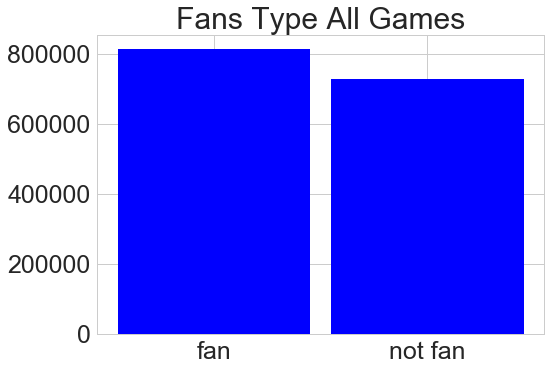

fan_of_team_playing
0    727748
1    814291
Name: comment_body, dtype: int64


In [383]:
# Show the number of bandwagon fans. Since it is such a small percentage, 
# it's not important to look into.
labels, values = zip(*Counter(data.fan_of_team_playing).items())

indexes = np.arange(len(labels))
width = .9

labels = ["fan","not fan"]
plt.bar(indexes, values, width,color='blue')
plt.tick_params(axis='both', which='major', labelsize=25)
plt.title('Fans Type All Games',fontsize=30)
plt.xticks(indexes, labels,fontsize=25)
plt.show()
print(data.groupby('fan_of_team_playing')['comment_body'].count())

In [385]:
comments, x_tokens, labels = make_data(data, target='fan_of_team_playing' )

In [387]:
with open('x_tokens.pickle', 'wb') as handle:
    pickle.dump(x_tokens, handle)
    
with open('labels.pickle', 'wb') as handle:
    pickle.dump(labels, handle)

In [388]:
# Split into test and train
train_data, test_data, train_labels, test_labels = \
    train_test_split(x_tokens, labels, test_size=0.10, random_state=42)  

In [389]:
# Count or TF-IDF vectorize, removing stop words.
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', lowercase=False, 
                             tokenizer=lambda text: text)
                             #tokenizer=lambda text: text, min_df=0.00002, max_df=0.005)

In [390]:
train_data_sparse = vectorizer.fit_transform(train_data)
test_data_sparse = vectorizer.transform(test_data)

/Users/kwheatley/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [391]:
# Save off word counts in csv
flat_list = [item for sublist in x_tokens for item in sublist]
counts = Counter(flat_list)

with open('dict.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in counts.items():
       writer.writerow([key, value])

In [392]:
counts = {}
for label in np.unique(labels):
    counts[label] = sum(labels == label)

print("Class counts:\n{}".format(counts))

Class counts:
{0: 727748, 1: 814291}


# Logistic Regression with L1 penalty

In [393]:
# load model
# with open('lasso_classifier.pkl', 'rb') as fid:
#     gnb_loaded = cPickle.load(fid)

In [395]:
lgst_l1 = SGDClassifier(loss="log", penalty="l1",alpha=0.0002)
lgst_l1.fit(train_data_sparse, train_labels)
# save the classifier
with open('lgst_l1_classifier.pkl', 'wb') as fid:
    pickle.dump(lgst_l1, fid)

In [450]:
#Create predictions and evaluate
pred_labels = lgst_l1.predict(test_data_sparse)
print("Training set score: {:.2f}".format(lgst_l1.score(train_data_sparse, train_labels)))
print("Test set score: {:.2f}".format(lgst_l1.score(test_data_sparse, test_labels)))
print("Number of features used: {}".format(np.sum(lgst_l1.coef_ != 0)))

print("Confusion Matrix...")
confusionMatrix = metrics.confusion_matrix(test_labels, pred_labels)
print(confusionMatrix)

Training set score: 0.54
Test set score: 0.54
Number of features used: 37
Confusion Matrix...
[[ 9931 63119]
 [ 7604 73550]]


In [397]:
lgst_l1.intercept_

array([0.0628262])

In [398]:
n=20
prediction_probs = lgst_l1.predict_proba(test_data_sparse)[:,0]
prob_actual = list(zip(prediction_probs, pred_labels,test_data))

print("Most likely fans")
for row in sorted(prob_actual)[:n]:
    print(row)
print()

print("Least likely fans")
for row in sorted(prob_actual)[-n:]:
    print(row)
print()

Most likely fans
(0.11506975518239893, 1, ["we'r", 'fuck', '.'])
(0.12276481404921158, 1, ["we'r", 'fuck'])
(0.13935376578900938, 1, ["we'r", 'not', '.', 'you', 'are', '.'])
(0.14142763310992834, 1, ["we'r", 'back', 'booiiiisss'])
(0.14142763310992834, 1, ["we'r", 'done'])
(0.14142763310992834, 1, ["we'r", 'innnn'])
(0.14142763310992834, 1, ["we'r", 'still', 'do', 'it'])
(0.15769160501774104, 1, ["we'r", 'back', '!'])
(0.15769160501774104, 1, ["we'r", 'not', '!'])
(0.17732741365517435, 1, ["we'r", 'both', 'shit', '.'])
(0.1782683263879422, 1, ['yeah', 'you', 'can', '.', "we'r", 'do', 'it', 'now', '.'])
(0.17922909904517004, 1, ['touchhdown', '!', "we'r", 'back', 'in', 'thi'])
(0.1813908909743458, 1, ['hey', 'defens', "we'r", 'still', 'play', 'a', 'game', 'here', 'can', 'you', 'not', 'do', 'that', '.'])
(0.18173987602352148, 1, ['at', 'least', 'see', 'which', 'offens', "we'r", 'get', 'today'])
(0.1817983773482862, 1, ['no', '.', "we'r", 'realli', 'not', '.'])
(0.18485684588460927, 1, ['

In [399]:
pd.DataFrame(prob_actual).to_csv("lgst_l1_test_results.csv")

In [400]:
n=50
classifier=lgst_l1

feature_names = vectorizer.get_feature_names()
    
topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
for coef, feat in topn_class1:
    print (coef, feat)

print()

for coef, feat in reversed(topn_class2):
    print (coef, feat)

-0.7935835750173537 romo
-0.643425855864641 nfl
-0.6403977623284971 chief
-0.6316721829167149 commerci
-0.6146852109330213 mcadoo
-0.5243437885213861 "
-0.4766823442938955 footbal
-0.46184955857087223 watch
-0.29005067325634387 look
-0.2780554424736509 ?
-0.2093371622153908 wow
-0.16383980313567498 holi
-0.09623859632943473 gruden
-0.09480435703495094 game
-0.08565668565120993 lol
-0.05964043278519245 giant
-0.024116255262251387 raider
0.0 
0.0 
0.0 #
0.0 ###adam
0.0 ###ahh
0.0 ###alert
0.0 ###anoth
0.0 ###at
0.0 ###bersin
0.0 ###big
0.0 ###block
0.0 ###boobiessssssss
0.0 ###brock
0.0 ###bronco
0.0 ###bruh
0.0 ###cardiac
0.0 ###cardiac-fucking-cat
0.0 ###cleveland
0.0 ###concret
0.0 ###confirm
0.0 ###crush
0.0 ###cutler
0.0 ###damn
0.0 ###darud
0.0 ###dilli
0.0 ###do
0.0 ###don't
0.0 ###dual
0.0 ###eject
0.0 ###exot
0.0 ###fade
0.0 ###fasteronoffens
0.0 ###fire

1.7406566079945351 we'r
1.021725627703007 defens
0.8064249687407291 fuck
0.5345507489140623 .
0.4652968460329633 offens
0.4

In [401]:
# lasso = Lasso(alpha=0.0002)
# lasso.fit(train_data, train_labels)

In [402]:
# #Create predictions and evaluate
# pred_labels = lasso.predict(test_data)
# print("Training set score: {:.2f}".format(lasso.score(train_data, train_labels)))
# print("Test set score: {:.2f}".format(lasso.score(test_data, test_labels)))
# print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

In [403]:
# n=50
# classifier=lasso

# feature_names = vectorizer.get_feature_names()
    
# topn_class1 = sorted(zip(classifier.coef_, feature_names))[:n]
# topn_class2 = sorted(zip(classifier.coef_, feature_names))[-n:]
# for coef, feat in topn_class1:
#     print (coef, feat)

# print()

# for coef, feat in reversed(topn_class2):
#     print (coef, feat)

# Logistic Regression with L2

In [404]:
# load the model
# with open('lasso_classifier.pkl', 'rb') as fid:
#     gnb_loaded = cPickle.load(fid)

In [405]:
lgst_l2 = SGDClassifier(loss="log", penalty="l2",alpha=5)
lgst_l2.fit(train_data_sparse, train_labels)
with open('lgst_l2_classifier.pkl', 'wb') as fid:
    pickle.dump(lgst_l2, fid)    

In [451]:
#Create predictions and evaluate
pred_labels = lgst_l2.predict(test_data_sparse)
print("Training set score: {:.2f}".format(lgst_l2.score(train_data_sparse, train_labels)))
print("Test set score: {:.2f}".format(lgst_l2.score(test_data_sparse, test_labels)))
#print("Number of features used: {}".format(np.sum(clf.coef_ != 0)))

print("Confusion Matrix...")
confusionMatrix = metrics.confusion_matrix(test_labels, pred_labels)
print(confusionMatrix)

Training set score: 0.47
Test set score: 0.47
Confusion Matrix...
[[73050     0]
 [81154     0]]


In [407]:
lgst_l2.intercept_

array([-0.00141271])

In [408]:
n=20
prediction_probs = lgst_l2.predict_proba(test_data_sparse)[:,0]
prob_actual = list(zip(prediction_probs, pred_labels,test_data))

print("Most likely fans")
for row in sorted(prob_actual)[:n]:
    print(row)
print()

print("Least likely fans")
for row in sorted(prob_actual)[-n:]:
    print(row)
print()

Most likely fans
(0.5001471758558642, 0, ['defens', ',', 'what', '.', 'the', '.', 'fuck', '.', 'are', '.', 'you', '.', 'do'])
(0.5001514875189828, 0, ['what', '.', 'the', '.', 'fuck', '.'])
(0.5001514875189828, 0, ['what', '.', 'the', '.', 'fuck', '.'])
(0.5001514875189828, 0, ['what', '.', 'the', '.', 'fuck', '.'])
(0.5001514875189828, 0, ['what', '.', 'the', '.', 'fuck', '.'])
(0.5001537073852551, 0, ['what', '.', 'in', '.', 'the', '.', 'fuck', '.'])
(0.5001543174504397, 0, ['fuck', '.', 'off', '.'])
(0.5001543174504397, 0, ['fuck', '.', 'off', '.'])
(0.5001543174504397, 0, ['fuck', 'it', '.', 'go', 'for', 'it', 'again', '.'])
(0.5001543174504397, 0, ['fuck', 'it', '.', 'might', 'as', 'well', '.'])
(0.5001543174504397, 0, ['what', '.', 'the', '.', 'fuck'])
(0.5001546018089624, 0, ['what', '.', 'the', '.', 'fuck', '.', 'is', '.', 'go', '.', 'on', '!', '?'])
(0.5001663203197536, 0, ['what', '.', 'a', '.', 'fuck', '.', 'game', '.'])
(0.5001708482095643, 0, ['fuck', '.', 'thi', '.'])
(0.

In [409]:
pd.DataFrame(prob_actual).to_csv("lgst_l2_test_results.csv")

In [424]:
n=20
classifier=lgst_l2

feature_names = vectorizer.get_feature_names()
    
topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
for coef, feat in topn_class1:
    print (coef, feat)

print()

for coef, feat in reversed(topn_class2):
    print (coef, feat)

-0.00011976714056524465 "
-6.76355842443442e-05 romo
-6.001973048469571e-05 commerci
-5.497361595617411e-05 nfl
-5.352171878150972e-05 chief
-5.2811589024600436e-05 footbal
-5.270919840158165e-05 watch
-5.1087496057231927e-05 mcadoo
-4.03712572398842e-05 cowboy
-3.8674324743078134e-05 gruden
-3.785648487740318e-05 wow
-3.7432694432376115e-05 patriot
-3.470761856183023e-05 night
-3.248841790434881e-05 raider
-3.208094750448591e-05 ben
-3.152647488232278e-05 toni
-3.0803379900042004e-05 dak
-3.0620148308811414e-05 giant
-3.0437228602221805e-05 alex
-3.0139833845407758e-05 charger

0.0006610610992615882 .
0.0004629645483025193 fuck
0.00026776728268921706 !
0.00024247747414130958 ,
0.00019058174837546392 defens
0.0001498801356833234 play
0.00013596855354731582 we'r
0.00013522235241105265 DG
0.0001225898842953879 run
0.00011244251713536207 ...
0.00010868874940001535 offens
0.00010787896017990827 thi
9.9046915701043e-05 hold
9.844319745946895e-05 ref
9.350817332421911e-05 good
9.294417699404

In [411]:
# rdg = Ridge(alpha=5)
# rdg.fit(train_data, train_labels)

In [412]:
# #Create predictions and evaluate
# pred_labels = rdg.predict(test_data)
# print("Training set score: {:.2f}".format(rdg.score(train_data, train_labels)))
# print("Test set score: {:.2f}".format(rdg.score(test_data, test_labels)))
# #print("Number of features used: {}".format(np.sum(clf.coef_ != 0)))

In [413]:
# n=50
# classifier=rdg

# feature_names = vectorizer.get_feature_names()
    
# topn_class1 = sorted(zip(classifier.coef_, feature_names))[:n]
# topn_class2 = sorted(zip(classifier.coef_, feature_names))[-n:]
# for coef, feat in topn_class1:
#     print (coef, feat)

# print()

# for coef, feat in reversed(topn_class2):
#     print (coef, feat)

# ElasticNet Regression

In [414]:
lgst_elnet = SGDClassifier(loss="log", penalty="elasticnet")
lgst_elnet.fit(train_data_sparse, train_labels)
with open('lgst_elnet_classifier.pkl', 'wb') as fid:
    pickle.dump(lgst_elnet, fid)    

In [415]:
#Create predictions and evaluate
pred_labels = lgst_elnet.predict(test_data_sparse)
print("Training set score: {:.2f}".format(lgst_elnet.score(train_data_sparse, train_labels)))
print("Test set score: {:.2f}".format(lgst_elnet.score(test_data_sparse, test_labels)))
print("Number of features used: {}".format(np.sum(lgst_elnet.coef_ != 0)))

Training set score: 0.58
Test set score: 0.58
Number of features used: 891


In [416]:
lgst_elnet.intercept_

array([0.08002113])

In [425]:
n=20
prediction_probs = lgst_elnet.predict_proba(test_data_sparse)[:,0]
prob_actual = list(zip(prediction_probs, pred_labels,test_data))

print("Most likely fans")
for row in sorted(prob_actual)[:n]:
    print(row)
print()

print("Least likely fans")
for row in sorted(prob_actual)[-n:]:
    print(row)
print()

Most likely fans
(0.10647441767924226, 1, ["we'r", 'fuck', '.'])
(0.11279388144279012, 1, ["we'r", 'fuck'])
(0.11854658916378213, 1, ['at', 'least', 'see', 'which', 'offens', "we'r", 'get', 'today'])
(0.13164997103780385, 1, ["we'r", 'back', 'booiiiisss'])
(0.13164997103780385, 1, ["we'r", 'done'])
(0.13164997103780385, 1, ["we'r", 'innnn'])
(0.13164997103780385, 1, ["we'r", 'still', 'do', 'it'])
(0.13226867677002674, 1, ["we'r", 'not', '.', 'you', 'are', '.'])
(0.13535367576022184, 1, ['of', 'cours', "we'r", 'go', 'to', 'fuck', 'it', 'up', '.', 'we', 'have', 'no', 'secondari', '.'])
(0.13558044568934535, 1, ['it', 'is', '3rd', 'down', ',', 'so', "we'r", 'due', '.'])
(0.1436102644481111, 1, ["we'r", 'back', '!'])
(0.1436102644481111, 1, ["we'r", 'not', '!'])
(0.14981354911451727, 1, ["we'r", 'fuck', 'gg', 'vike'])
(0.15183264934873364, 1, ['yeah', 'you', 'can', '.', "we'r", 'do', 'it', 'now', '.'])
(0.15272788251902103, 1, ['oh', ',', 'so', "we'r", 'call', 'offens', 'hold', 'now'])
(0.

In [426]:
pd.DataFrame(prob_actual).to_csv("lgst_elnet_test_results.csv")

In [427]:
n=20
classifier=lgst_elnet

feature_names = vectorizer.get_feature_names()
    
topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
for coef, feat in topn_class1:
    print (coef, feat)

print()

for coef, feat in reversed(topn_class2):
    print (coef, feat)

-1.1242282597054742 mcadoo
-1.103582890058249 chief
-1.0283241172132462 romo
-0.9623204543423974 nfl
-0.9581012654932509 gruden
-0.9354537525390547 commerci
-0.8897461075348608 patriot
-0.8389952310924411 cowboy
-0.8137646536961007 rex
-0.7932570633716163 collinsworth
-0.7859264884698535 fantasi
-0.7803465052429476 espn
-0.7773310863704103 raven
-0.758210193250517 redskin
-0.7580667135932241 kc
-0.7572729545462727 raider
-0.7551536553243069 charger
-0.7483306959325533 alex
-0.7421243491590797 footbal
-0.7252453546413405 song

1.8064271008970711 we'r
1.1323871088394408 defens
0.9919896319515082 we'v
0.849904466285376 fuck
0.7953156495343134 gg
0.7562093595332735 offens
0.7412796472326515 secondari
0.7275106306431797 today
0.70660168012048 3rd
0.6533341755564072 hold
0.5929094265112091 d
0.5845484644345018 tackl
0.5814195120521151 drive
0.5633525142679146 doug
0.5294932401420978 shula
0.5294784441073573 half
0.5111356374099452 .
0.5057544591751417 pleas
0.4909343835836392 we'll
0.4820651

In [428]:
test_labels.shape

(154204,)

In [449]:
print("Accuracy...")
print(lgst_elnet.score(test_data_sparse, test_labels))

print("Confusion Matrix...")
confusionMatrix = metrics.confusion_matrix(test_labels, pred_labels)
print(confusionMatrix)

Accuracy...
0.5753612098259449
Confusion Matrix...
[[25009 48041]
 [17440 63714]]


In [442]:
# elnet = ElasticNet(alpha=0.0001, l1_ratio=0.25)
# elnet.fit(train_data, train_labels)

In [443]:
# n=50
# classifier=elnet

# feature_names = vectorizer.get_feature_names()
    
# topn_class1 = sorted(zip(classifier.coef_, feature_names))[:n]
# topn_class2 = sorted(zip(classifier.coef_, feature_names))[-n:]
# for coef, feat in topn_class1:
#     print (coef, feat)

# print()

# for coef, feat in reversed(topn_class2):
#     print (coef, feat)

# Logistic Regression

In [445]:
# Train model
lgreg = LogisticRegression()
lgreg.fit(train_data_sparse, train_labels)
with open('lgreg_classifier.pkl', 'wb') as fid:
    pickle.dump(lgreg, fid)    

In [446]:
train_labels.sum()
# 1387844
# 732907
732907/1387844

0.5280903329192618

In [447]:
lgreg.intercept_

array([0.22849132])

In [453]:
#Create predictions and evaluate
pred_labels = lgreg.predict(test_data_sparse)
acc = metrics.accuracy_score(test_labels, pred_labels)
print("Accuracy on test set: {:.02%}".format(acc))
print('Test Data:')

feature_names = vectorizer.get_feature_names()
# class_labels = lgreg.classes_
# print(class_labels)
# print(classification_report(test_labels, pred_labels, target_names = class_labels, digits=1))
#print(classification_report(test_labels, pred_labels, target_names = ['fan_lose_close', 'fan_lose_notclose', 'fan_win_close', 'fan_win_notclose'], digits=3))

print("Confusion Matrix...")
confusionMatrix = metrics.confusion_matrix(test_labels, pred_labels)
print(confusionMatrix)

Accuracy on test set: 59.71%
Test Data:
Confusion Matrix...
[[35319 37731]
 [24399 56755]]


In [457]:
n=20
classifier=lgreg

feature_names = vectorizer.get_feature_names()

topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
for coef, feat in topn_class1:
    print (coef, feat)

print()

for coef, feat in reversed(topn_class2):
    print (coef, feat)

-2.923715366021814 #eagl
-2.755426851587467 mcdonough
-2.669645551533331 DG.DGDGDGDG
-2.638688759946376 tune
-2.4446295670105966 juejueju
-2.4274261932542798 skycam
-2.4183707060217663 tirico
-2.4164959461391455 rex
-2.379280496369442 tony'
-2.355421705939822 aedeo
-2.3444517694359583 jumanji
-2.289675121837349 yahoo
-2.2499635662085766 england'
-2.2225865015500754 skatterbug
-2.211548586865005 megyn
-2.1915758056484984 wembley
-2.17099212735703 juri
-2.1637651854670374 gruden'
-2.1434772192645366 sergio
-2.13214120223407 heineken

3.116647589248028 cyru
2.724470053987755 dola
2.7026392091230957 burton
2.6892941860713226 hollist
2.652478559387787 noy
2.6323791316272165 we'r
2.6033190375600985 timnog
2.569196575834768 bolden
2.5306872540788854 debo
2.5066221063059535 gannon
2.4933154702357463 sendejo
2.401825355363758 ifedi
2.35150885362916 bersin
2.3373693170843395 robison
2.331170481903467 rees
2.319135996172384 we'v
2.2990700009 kittl
2.288698940284677 boz
2.2771850013929815 harmon
2

# Exploration

In [459]:
comments = data
comments['comment_body'] = comments.comment_body.map(lambda x: x.lower())
chaz_comments = comments[comments.comment_body.str.contains('ournette')]

In [460]:
pd.DataFrame(\
comments.groupby(['submission_title','fan_of_team_playing']) \
             ['comment_body'].count().reset_index()).sort_values(by='submission_title',\
                                                                 ascending=False)\
.to_csv("temp.csv")

In [461]:
pd.DataFrame(\
chaz_comments.groupby(['submission_title','fan_of_team_playing']) \
             ['comment_body'].count().reset_index()).sort_values(by='comment_body',\
                                                                 ascending=False)


,submission_title,fan_of_team_playing,comment_body
5,Game Thread: Baltimore Ravens (2-0) at Jacksonville Jaguars (1-1),0,81
33,Game Thread: Jacksonville Jaguars (0-0) at Houston Texans (0-0),1,73
43,Game Thread: Jacksonville Jaguars (2-2) at Pittsburgh Steelers (3-1),1,43
32,Game Thread: Jacksonville Jaguars (0-0) at Houston Texans (0-0),0,37
57,Game Thread: Los Angeles Rams (3-2) at Jacksonville Jaguars (3-2),1,33
42,Game Thread: Jacksonville Jaguars (2-2) at Pittsburgh Steelers (3-1),0,33
41,Game Thread: Jacksonville Jaguars (2-1) at New York Jets (1-2),1,28
54,Game Thread: Los Angeles Chargers (3-5) at Jacksonville Jaguars (5-3),0,26
56,Game Thread: Los Angeles Rams (3-2) at Jacksonville Jaguars (3-2),0,25
6,Game Thread: Baltimore Ravens (2-0) at Jacksonville Jaguars (1-1),1,24


In [254]:
chaz_comments

,Unnamed: 0,author_flair,submission_title,comment_body,fan_of_team_playing,bandwagon,fan_of_team_playing_w_bandwagon,fan_binary
70831,70831,Steelers,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),haley: *barely runs the ball at all in the first half*\n\nhaley: *calls 4 rush plays in a row*\n\nthis man can find no balance in his life.,1,0,1,1
70976,70976,Patriots,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),"""in 2006, haley filed a 1.5 million-dollar lawsuit against mcdonald's after his wife found a dead rat in her salad.""\n\nfrom todd haley's wikipedia. honestly, i'm not surprised.",0,0,0,0
71230,71230,Steelers,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),todd haley seems to have forgotten that play action is an option,1,0,1,1
72969,72969,Steelers,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),haley called decent plays last week so expect us to throw 50% screens and 3rd and 1 deep balls all game,1,0,1,1
73595,73595,Seahawks,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),todd haley seems like a fun guy lol,0,0,0,0
73605,73605,Vikings,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),todd haley probably slams 3 whiskeys at halftime every week to maintain his image.,0,0,0,0
73999,73999,Steelers,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),"who's ready for haley to take this momentum and call run, run, pass?",1,0,1,1
74890,74890,no value,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),only todd haley could ruin an offense this stacked with talent,0,0,0,0
75066,75066,Steelers,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),todd haley loves the delayed handoff on first and 10 for a loss of yardage!!!!!!!!!!!!,1,0,1,1
76761,76761,Steelers,Game Thread: Green Bay Packers (5-5) at Pittsburgh Steelers (8-2),not jinxing it but we haven't seen a todd haley bomb(tm) yet,1,0,1,1


In [465]:
pd.DataFrame(chaz_comments.groupby(['submission_title','fan_of_team_playing'])\
             ['comment_body'].count().reset_index())

,submission_title,fan_of_team_playing,comment_body
0,Game Thread: Atlanta Falcons (0-1) at Pittsburgh Steelers (1-0),1,4
1,Game Thread: Atlanta Falcons (3-2) at New England Patriots (4-2),0,1
2,Game Thread: Atlanta Falcons (5-4) at Seattle Seahawks (6-3),0,1
3,Game Thread: Atlanta Falcons (5-4) at Seattle Seahawks (6-3),1,1
4,Game Thread: Atlanta Falcons (9-5) at New Orleans Saints (10-4),1,1
5,Game Thread: Baltimore Ravens (2-0) at Jacksonville Jaguars (1-1),0,1
6,Game Thread: Baltimore Ravens (7-5) at Pittsburgh Steelers (10-2),0,5
7,Game Thread: Baltimore Ravens (7-5) at Pittsburgh Steelers (10-2),1,44
8,Game Thread: Buffalo Bills (8-6) at New England Patriots (11-3),0,3
9,Game Thread: Chicago Bears (1-1) at Tennessee Titans (1-1),1,1


In [115]:
percent_chart = pd.read_csv("percent_chart.csv")
percent_chart = percent_chart.sort_values(by='sort_index')
percent_chart = percent_chart.reset_index()

In [116]:
percent_chart.head()

,index,submission_title,not_fan,fan,total_comments,percent_not_fan,percent_not_fans,date,sort_index
0,0,Game Thread: Arizona Cardinals (0-0) at Dallas Cowboys (0-0),4129,1336,5465.0,0.755535,50-75%,8/3/17,1.0
1,1,Game Thread: Houston Texans (0-0) at Carolina Panthers (0-0),3400,2043,5443.0,0.624656,50-75%,8/9/17,2.0
2,2,Game Thread: Denver Broncos (0-0) at Chicago Bears (0-0),1266,1609,2875.0,0.440348,25-50%,8/10/17,3.0
3,3,Game Thread: Jacksonville Jaguars (0-0) at New England Patriots (0-0),143,925,1068.0,0.133895,0-25%,8/10/17,4.0
4,4,Game Thread: Minnesota Vikings (0-0) at Buffalo Bills (0-0),272,794,1066.0,0.255159,0-25%,8/10/17,5.0


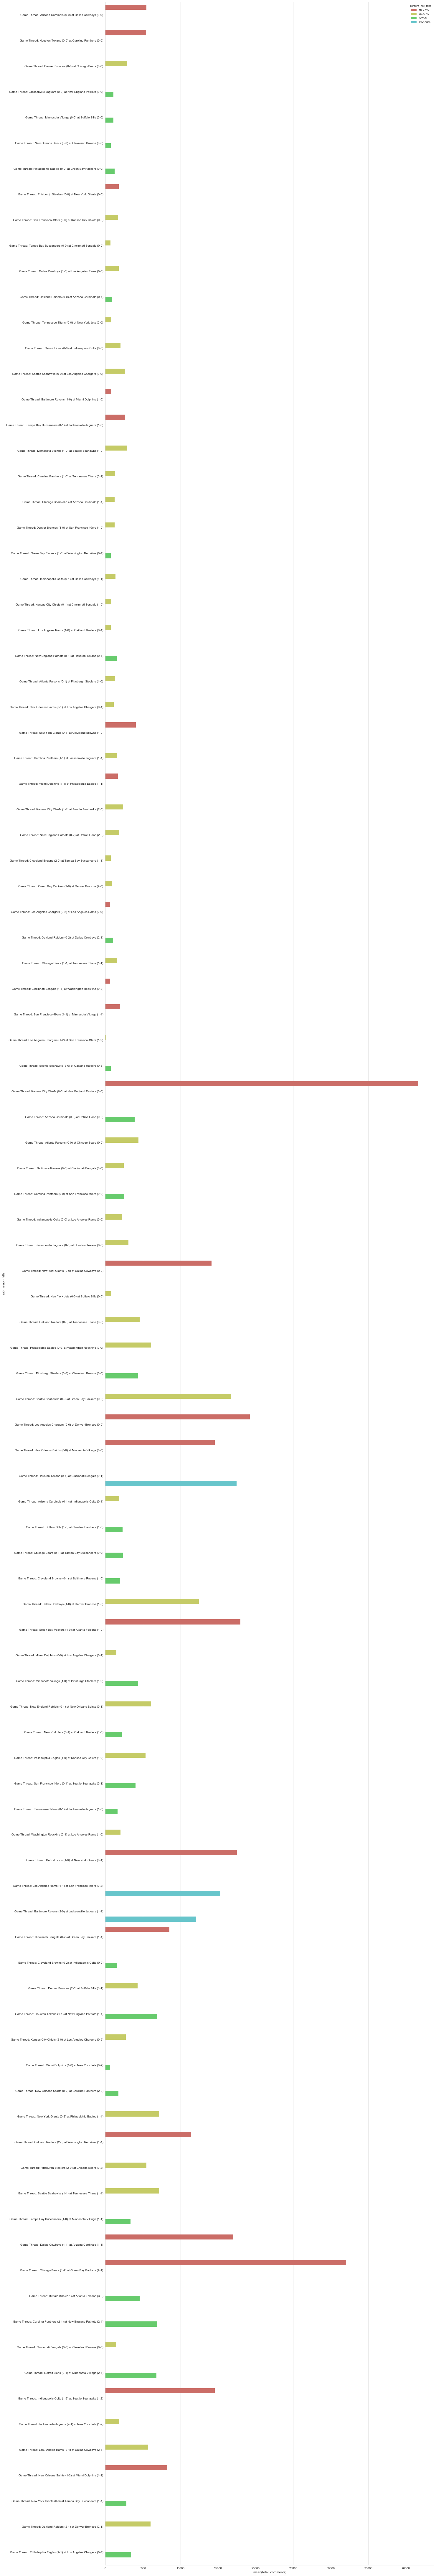

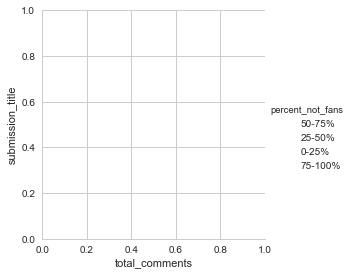

In [209]:
import seaborn as sns
import pandas as pd

fig, ax = plt.subplots()
fig.set_size_inches(20, 160)

ax = sns.factorplot(orient='h', ax=ax, y='submission_title', x='total_comments', \
                   hue='percent_not_fans', kind='bar', data=percent_chart.head(100) )
sns.set_style("whitegrid") 
sns.set_palette("hls")
# ax.add_legend(label_order = ['0-25%',''0','-1','-2''])
plt.show()